In [3]:
!gdown 1HMy8IFlOx_uWgBABUEUc5m1TVnRWScjB

Downloading...
From: https://drive.google.com/uc?id=1HMy8IFlOx_uWgBABUEUc5m1TVnRWScjB
To: /content/open.zip
100% 19.2G/19.2G [03:18<00:00, 96.5MB/s]


In [4]:
!unzip -qq "open.zip"

In [5]:
import os
import gc
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import sigmoid_focal_loss

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

from google.colab import files

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [7]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

In [8]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = F.sigmoid(inputs) # sigmoid를 통과한 출력이면 주석처리

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [9]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.block(x)
        return x

In [10]:
class UNetPP(nn.Module):
    def __init__(self):
        super(UNetPP, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.down = nn.MaxPool2d(2)
        self.last = nn.Conv2d(32, 1, kernel_size=1)

        self.conv0_0 = Block(3, 32)
        self.conv0_1 = Block(32 + 64, 32)
        self.conv0_2 = Block(32 * 2 + 64, 32)
        self.conv0_3 = Block(32 * 3 + 64, 32)
        self.conv0_4 = Block(32 * 4 + 64, 32)

        self.conv1_0 = Block(32, 64)
        self.conv1_1 = Block(64 + 128, 64)
        self.conv1_2 = Block(64 * 2 + 128, 64)
        self.conv1_3 = Block(64 * 3 + 128, 64)

        self.conv2_0 = Block(64, 128)
        self.conv2_1 = Block(128 + 256, 128)
        self.conv2_2 = Block(128 * 2 + 256, 128)

        self.conv3_0 = Block(128, 256)
        self.conv3_1 = Block(256 + 512, 256)

        self.conv4_0 = Block(256, 512)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.down(x0_0))
        x2_0 = self.conv2_0(self.down(x1_0))
        x3_0 = self.conv3_0(self.down(x2_0))
        x4_0 = self.conv4_0(self.down(x3_0))

        x0_1 = self.conv0_1(torch.cat([x0_0, self.up(x1_0)], dim=1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up(x2_0)], dim=1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up(x3_0)], dim=1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up(x4_0)], dim=1))

        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up(x1_1)], dim=1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up(x2_1)], dim=1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up(x3_1)], dim=1))

        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up(x1_2)], dim=1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up(x2_2)], dim=1))

        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], dim=1))

        output = self.last(x0_4)

        return output

In [11]:
!gdown 1Dhf-wJSwS5088DLqvF1wQx-zEO2SP9C0

Downloading...
From: https://drive.google.com/uc?id=1Dhf-wJSwS5088DLqvF1wQx-zEO2SP9C0
To: /content/UNet++_20.pth
100% 36.8M/36.8M [00:01<00:00, 23.0MB/s]


In [17]:
gc.collect()
torch.cuda.empty_cache()

transform = A.Compose(
    [
        A.RandomCrop(224, 224),
        A.RandomBrightnessContrast(),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

transform = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)

test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_idx = [3, 5, 7, 9]

model = torch.load(f'./UNet++_20.pth').to(device)
# model = UNetPP().to(device)

dice_loss = DiceLoss()
bce_loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
print(sum(p.numel() for p in model.parameters()))

9163329


100%|██████████| 447/447 [05:35<00:00,  1.33it/s]


Epoch 21, Loss: 0.3581629207470273


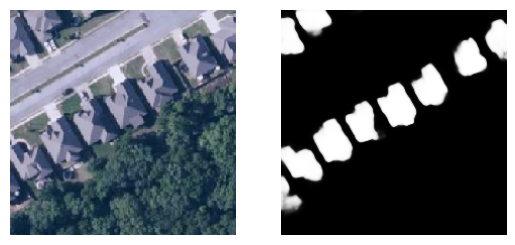

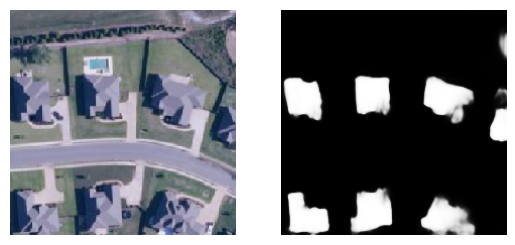

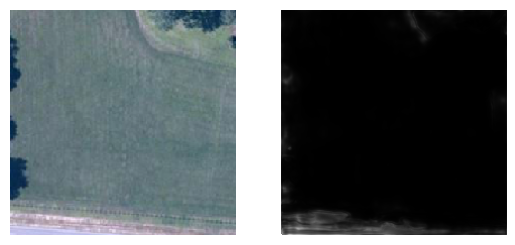

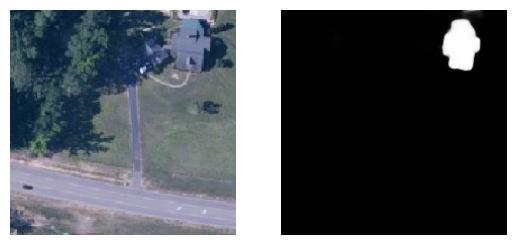

100%|██████████| 447/447 [05:29<00:00,  1.36it/s]


Epoch 22, Loss: 0.34328213580769446


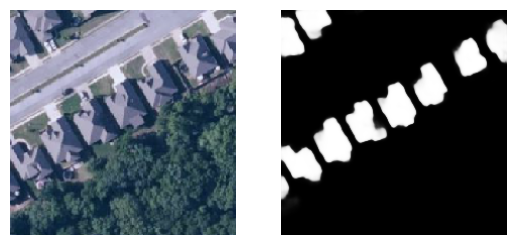

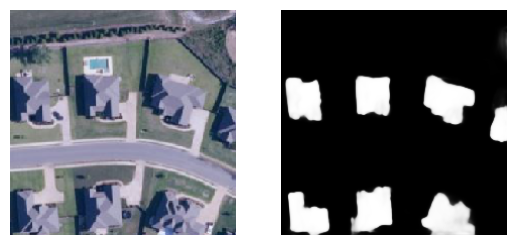

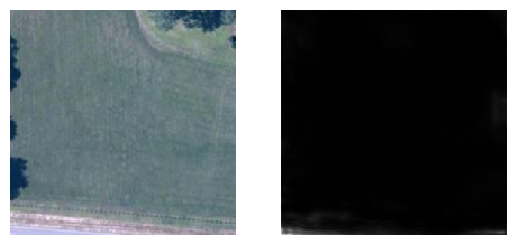

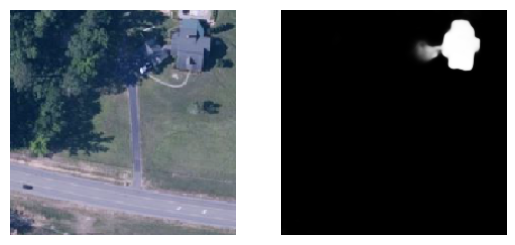

100%|██████████| 447/447 [05:30<00:00,  1.35it/s]


Epoch 23, Loss: 0.3367436361192857


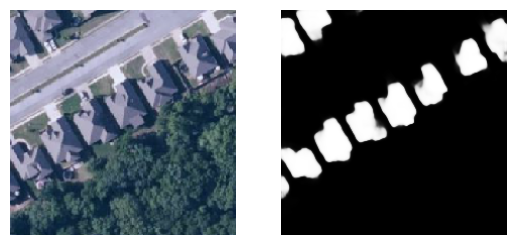

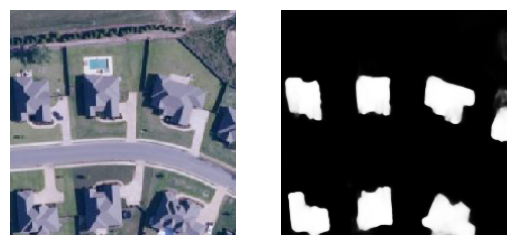

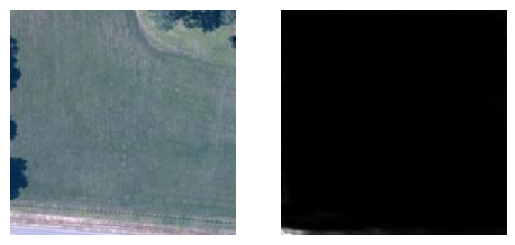

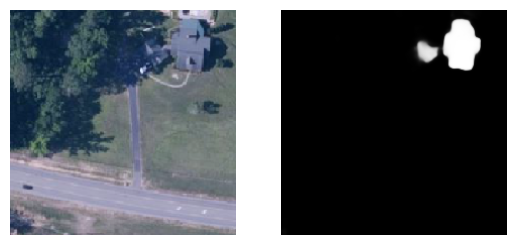

100%|██████████| 447/447 [05:33<00:00,  1.34it/s]


Epoch 24, Loss: 0.3380587344001604


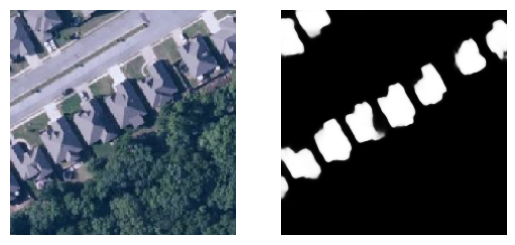

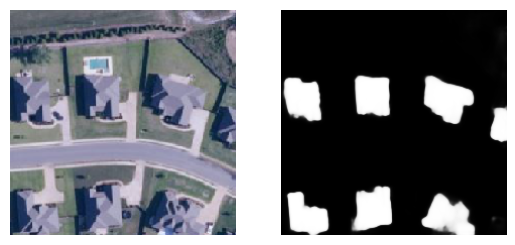

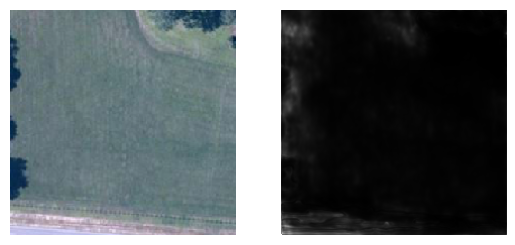

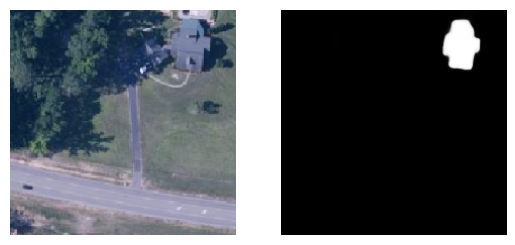

100%|██████████| 447/447 [05:32<00:00,  1.34it/s]


Epoch 25, Loss: 0.3421219484651382


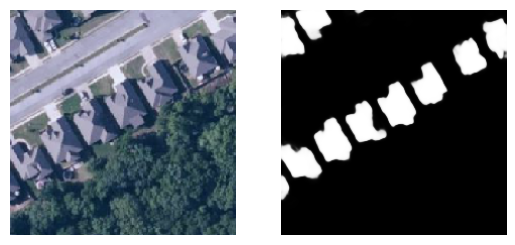

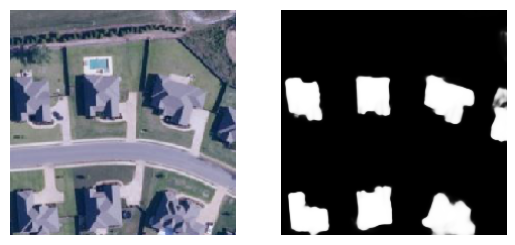

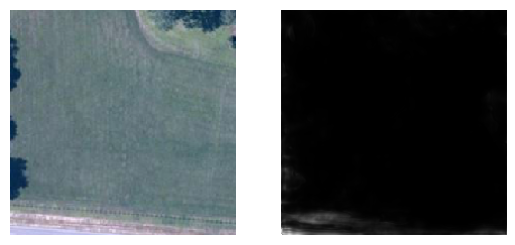

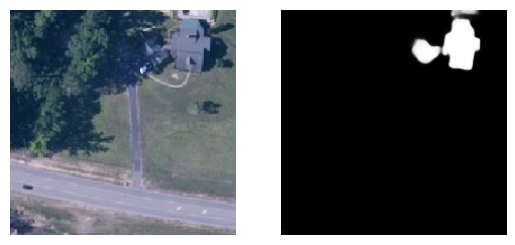

100%|██████████| 447/447 [05:31<00:00,  1.35it/s]


Epoch 26, Loss: 0.32916586271068393


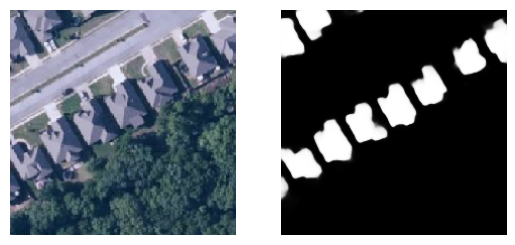

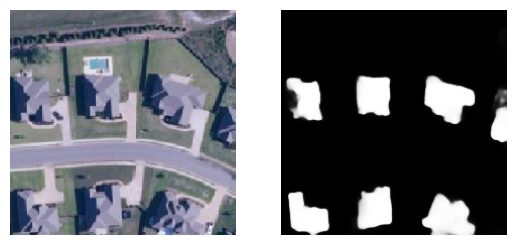

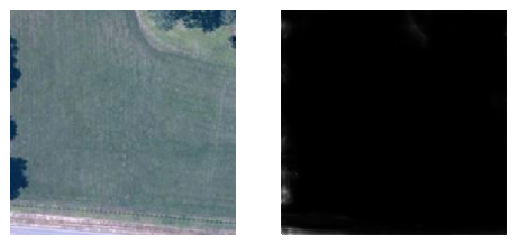

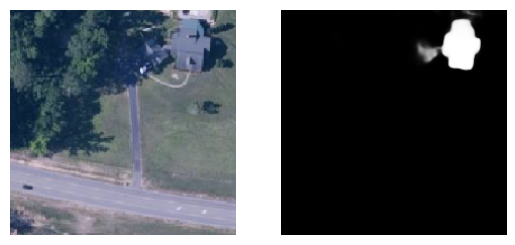

100%|██████████| 447/447 [05:32<00:00,  1.34it/s]


Epoch 27, Loss: 0.32924382878629954


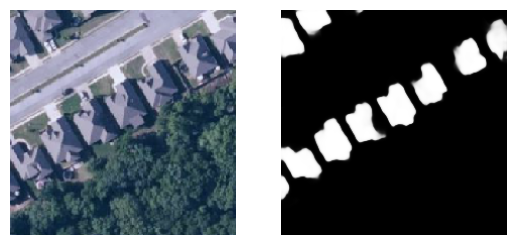

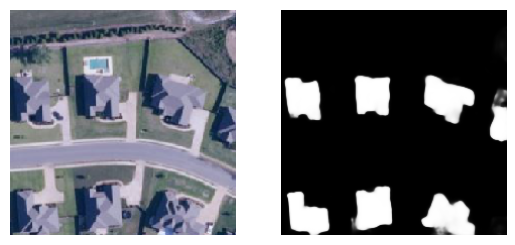

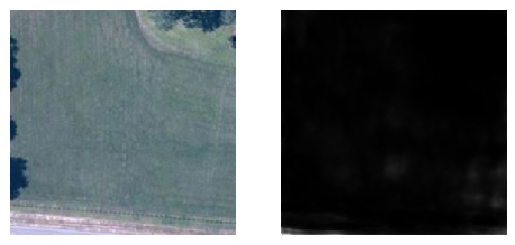

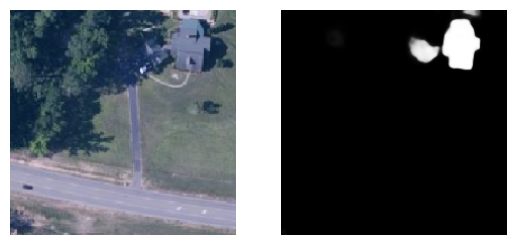

100%|██████████| 447/447 [05:33<00:00,  1.34it/s]


Epoch 28, Loss: 0.3246422845711911


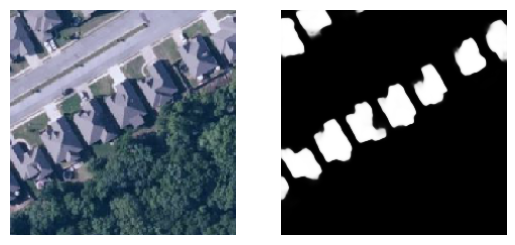

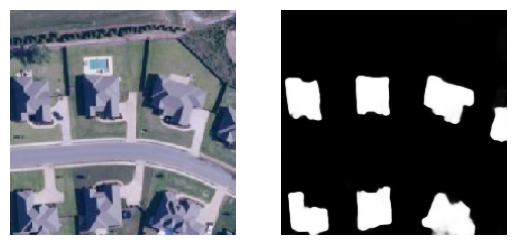

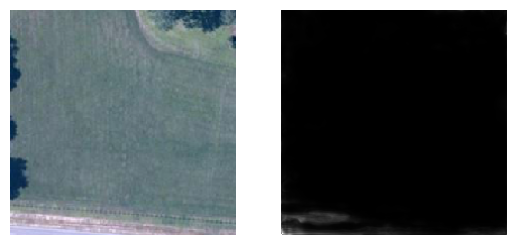

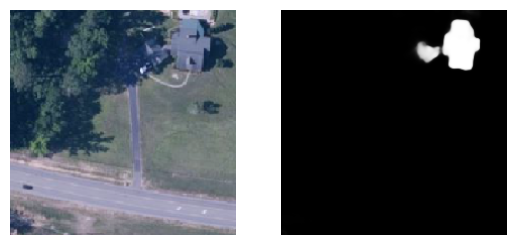

100%|██████████| 447/447 [05:33<00:00,  1.34it/s]


Epoch 29, Loss: 0.3348707821078482


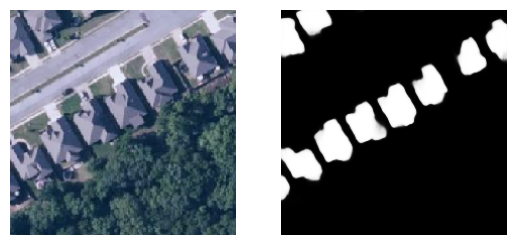

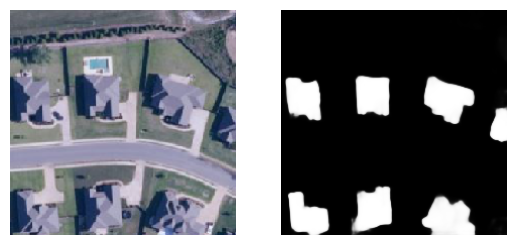

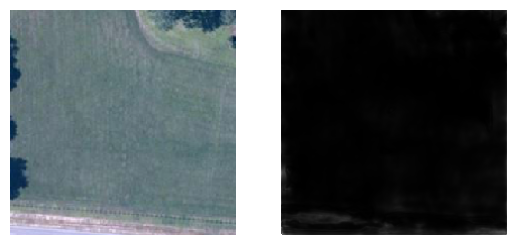

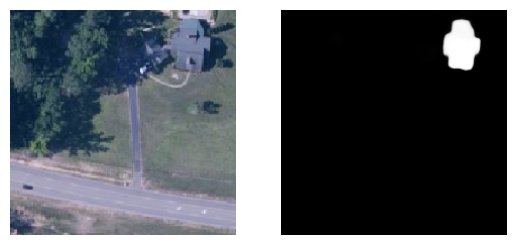

100%|██████████| 447/447 [05:33<00:00,  1.34it/s]


Epoch 30, Loss: 0.32617877110405524


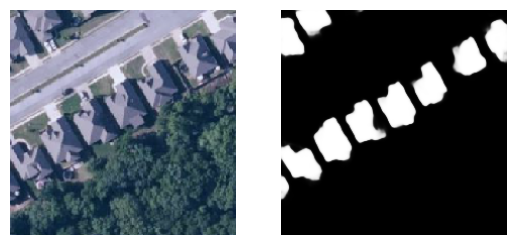

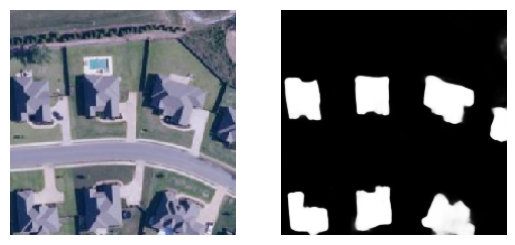

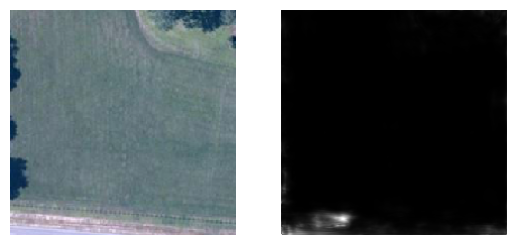

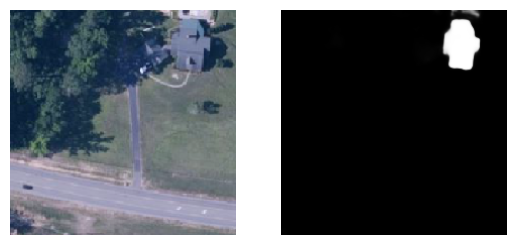

100%|██████████| 447/447 [05:34<00:00,  1.34it/s]


Epoch 31, Loss: 0.3296911664457129


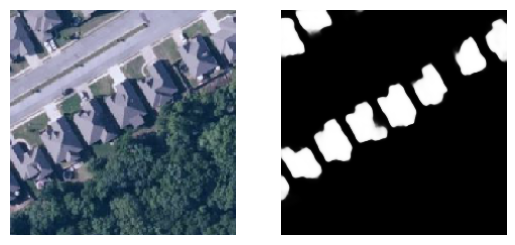

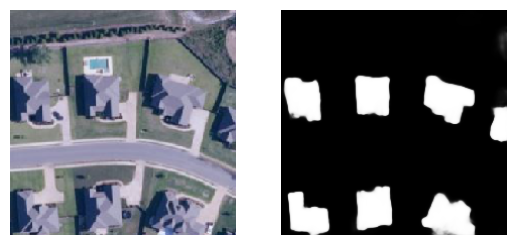

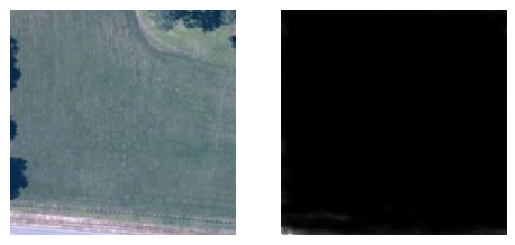

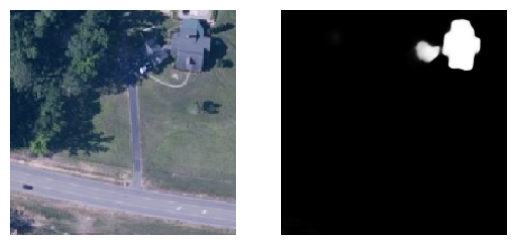

In [19]:
for epoch in range(20, 31):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = dice_loss(outputs, masks)
        loss += bce_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')
    with torch.no_grad():
        model.eval()
        for i in test_idx:
            image = test_dataset[i]
            input_image = image.to(device)
            mask = model(input_image.float().to(device).unsqueeze(0))[0]
            mask = torch.sigmoid(mask).cpu().numpy()
            mask = np.squeeze(mask, axis=0)
            # mask = (mask > 0.35).astype(np.uint8)
            plt.figure()
            plt.subplot(1, 2, 1)
            image = (image - image.min()) / (image.max() - image.min())
            plt.imshow(image.permute(1, 2, 0))
            plt.axis('off')
            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            plt.show()

In [20]:
torch.save(model, f'./UNet++_30.pth')
files.download(f'./UNet++_30.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
transform = A.Compose(
    [
        A.Normalize(),
        ToTensorV2()
    ]
)

test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8)

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '':
                result.append(-1)
            else:
                result.append(mask_rle)

100%|██████████| 3790/3790 [14:31<00:00,  4.35it/s]


In [22]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

submit.to_csv(f'./UNet++_30.csv', index=False)
files.download(f'./UNet++_30.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

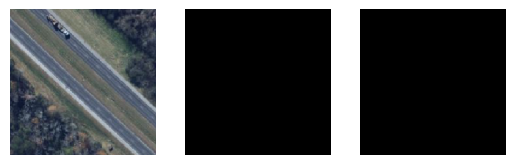

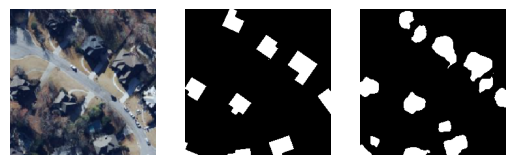

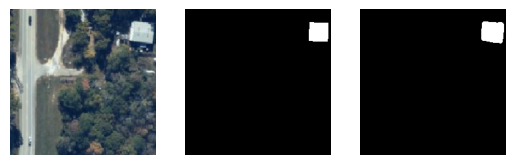

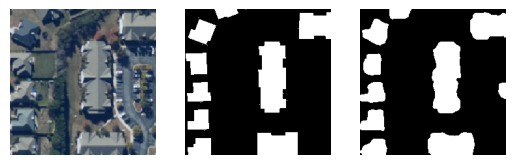

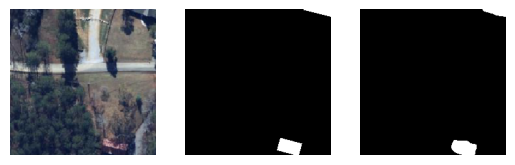

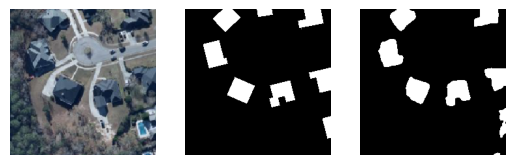

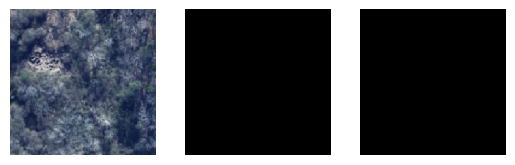

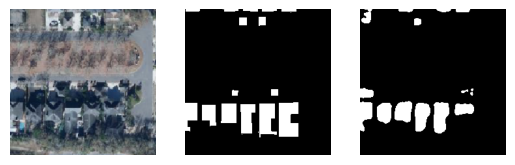

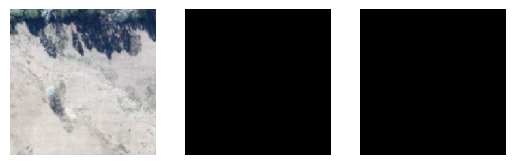

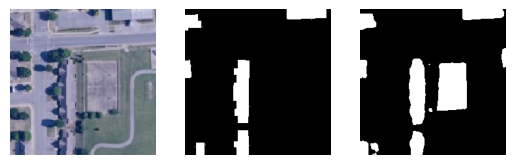

In [27]:
transform = A.Compose(
    [
        A.CenterCrop(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, num_workers=2)

with torch.no_grad():
    model.eval()
    for i in range(10):
        image, ground = dataset[i]
        input_image = image.to(device)
        mask = model(input_image.float().to(device).unsqueeze(0))[0]
        mask = torch.sigmoid(mask).cpu().numpy()
        mask = np.squeeze(mask, axis=0)
        mask = (mask > 0.35).astype(np.uint8)
        plt.figure()
        plt.subplot(1, 3, 1)
        image = (image - image.min()) / (image.max() - image.min())
        plt.imshow(image.permute(1, 2, 0))
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(ground, cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.show()